# CONTEXTO DO PROBLEMA

A Blocker Fraude Company é uma empresa especializada na detecção de fraudes em transações financeiras feitas através de dispositivos móveis. A empresa tem um serviço chamado “Blocker Fraud” no qual garante o bloqueio de transações fraudulentas.

E o modelo de negócio da empresa é do tipo Serviço com a monetização feita por performance do serviço prestado, ou seja, o usuário paga uma taxa fixa sobre o sucesso na detecção de fraude das transações do cliente.

Porém, a Blocker Fraud Company está em fase de expansão no Brasil e para adquirir clientes mais rapidamente, ela adotou uma estratégia muito agressiva. A estratégia funciona da seguinte forma:

1. A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
2. A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
3. A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.


Com essa estratégia agressiva a empresa assume os riscos em falhar na detecção de fraude e é remunerada na detecção assertiva das fraudes.

Para o cliente, é um excelente negócio contratar a Blocker Fraud Company. Apesar da taxa cobrada ser muito alta sobre o sucesso, 25%, a empresa reduz seus custos com transações fraudulentas detectadas corretamente e ainda o prejuízo causado por um erro do serviço de anti-fraude será coberto pela própria Blocker Fraud Company.

Para a empresa, além de conseguir muitos clientes com essa estratégia arriscada em garantir o reembolso no caso de uma falha na detecção de fraude do cliente, ela depende somente da precisão e da acurácia dos modelos construídos pelos seus Cientistas de Dados, ou seja, quanto mais preciso for o modelo “Blocker Fraud”, maior o faturamento da empresa. Porém, se o modelo tiver baixa precisão, a empresa poderá ter um prejuízo enorme.

# O PROBLEMA

Você foi contratado como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Ao final da sua consultoria, você precisa entregar ao CEO da Blocker Fraud Company um modelo em produção no qual seu acesso será feito via API, ou seja, os clientes enviarão suas transações via API para que o seu modelo as classifique como fraudulentas ou legítimas.

Além disso, você precisará entregar um relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:

1. Qual a Precisão e Acurácia do modelo?
2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

# ENTENDIMENTO DO PROBLEMA

**Motivação:** Alta estratégia de crescimento para expansão sobre os resultados de detecção das fraudes.

**Causa Raiz do Problema:** Criar um modelo capaz de detectar fraudes com alta acuracia.

**Tipo de Problema:** Detecção de Fraude.

**Potênciais Métodos:** Classificação.

**Granularidade:** Classificação de Fraude por Transação.

**Entraga da Solução:** WebApp contendo a predição e o Relatório.

**Dados para Resolver o Problema:** [Kaggle](https://www.kaggle.com/ealaxi/paysim1).

# 0.0 IMPORTS

In [1]:
# Manipulation
import pandas as pd
import inflection

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## 0.1 Funções Auxiliares

## 0.2 Carregamento de Dados

In [2]:
path = 'C:/Users/jhonatans/projects/ML/Classification/Financial-Fraud-Detection/' # path project
df = pd.read_csv(path + 'data/fraud_data.csv') # load data

df.head() # show data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [8]:
print(f'Qty. Rows: {df.shape[0]}')
print(f'Qty. Columns: {df.shape[1]}')

Qty. Rows: 6362620
Qty. Columns: 11


## 1.2 Renomeação de Colunas

In [30]:
# Snakecase
snakecase = lambda x: inflection.underscore(x)

# Alter name columns
df.columns = list(map(snakecase, list(df.columns)))
df.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Tipo de Dados

In [31]:
df.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.4 Verificação de Dados Ausentes

In [32]:
df.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.5 Mudança do Tipo de Dados

## 1.6 Estatística Descritiva

### 1.6.1 Atributos Numéricos

In [50]:
numerical = df.select_dtypes(include=['int64', 'float64'])  # Select numerical data
describe = numerical.describe().T  # describe data

describe['kurtosis'] = numerical.apply(lambda x: x.kurtosis())  # add kurtosis in describe
describe['skew'] = numerical.apply(lambda x: x.skew())  # add skew in describe

describe

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,0.329071,0.375177
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,1797.956705,30.993949
oldbalance_org,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,32.964879,5.249136
newbalance_orig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,32.066985,5.176884
oldbalance_dest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,948.674125,19.921758
newbalance_dest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,862.156508,19.352302
is_fraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00,769.702982,27.779538
is_flagged_fraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00,397659.062500,630.603629


**Insight:**

### 1.6.2 Atributos Categóricos

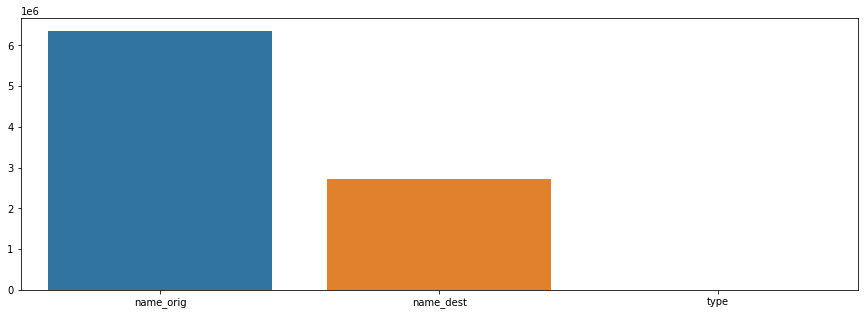

In [83]:
# Select categorical data
categorical = df.select_dtypes(include=['object'])

# Count unique values 
values_cat = categorical.apply(lambda x: len(x.unique())).sort_values(ascending=False)

# Figure
plt.figure(figsize=(15, 5))
sns.barplot(x=values_cat.index, y=values_cat.values);

**Insight:**

# 2.0 FEATURE ENGINEERING

# 3.0 FILTRAGEM DE DADOS

# 4.0 EDA

# 5.0 PREPRAÇÃO DE DADOS

# 6.0 SELEÇÃO DE FEATURE

# 7.0 MACHINE LEARNING

# 8.0 AJUSTE DE HIPERPARAMETROS

# 9.0 TRADUÇÃO E INTERPRETAÇÃO

# 10.0 DEPLOY MODELO

### + Dicionario de Dados


**step**: mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type:** Tipo da transação.

**amount:** valor da transação em moeda local.

**nameOrig:** cliente que iniciou a transação.

**oldbalanceOrg:** saldo inicial antes da transação.

**newbalanceOrig:** Saldo depois da transação.

**nameDest:** cliente que é o destinatário da transação.

**oldbalanceDest:** destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**newbalanceDest:** novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**isFraud:** Target.

**isFlaggedFraud:** O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.
